In [1]:
import gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v0')

In [3]:
MAX_EPISODE_LENGTH = 250
LEARNING_RATE = 0.2
DISCOUNT_FACTOR = 1

BINS = 20
NUM_STATES = BINS ** 4

CART_POSITION = np.linspace(-4.8, 4.8, BINS)
CART_VELOCITY = np.linspace(-1, 1, BINS)
POLE_ANGLE = np.linspace(-0.418, 0.418, BINS)
POLE_ANGULAR_VELOCITY = np.linspace(-3, 3, BINS)


Q = defaultdict(lambda: np.random.uniform(1, -1))
state_visitation_counts = []


def to_bins(value, bins):
    return np.digitize(x=[value], bins=bins)[0]


def to_discrete_state(obs):
    x, v, theta, omega = obs
    state = (to_bins(x, CART_POSITION),
             to_bins(v, CART_VELOCITY),
             to_bins(theta, POLE_ANGLE),
             to_bins(omega, POLE_ANGULAR_VELOCITY))
    return state


def policy(state, exploration_rate):
    if np.random.uniform(0, 1) < exploration_rate:
        return env.action_space.sample()
    q_values = [Q[(state, action)] for action in range(env.action_space.n)]
    return np.argmax(q_values)


def q_learning(num_episodes, exploration_rate=0.5, exploration_rate_decay=0.9, min_exploration_rate=0.01):
    rewards = []
    print("Performing Q-learning with %d states" % NUM_STATES)
    for episode in range(num_episodes):
        rewards.append(0)
        obs = env.reset()
        state = to_discrete_state(obs)

        for t in range(MAX_EPISODE_LENGTH):
            action = policy(state, exploration_rate)

            obs, reward, done, _ = env.step(action)

            next_state = to_discrete_state(obs)
            optimal_next_action = policy(next_state, exploration_rate)

            Q[(state, action)] = (1-LEARNING_RATE)*Q[(state, action)] + \
                LEARNING_RATE*(reward + DISCOUNT_FACTOR *
                               Q[(next_state, optimal_next_action)])
            state_visitation_counts.append(state)

            state = next_state

            rewards[-1] += reward
            if done:
                break

        exploration_rate = max(exploration_rate_decay *
                               exploration_rate, min_exploration_rate)
        if episode % (num_episodes / 100) == 0:
            print("Mean Reward: ", np.mean(rewards[-int(num_episodes / 100):]))
            state_visitations = np.array(state_visitation_counts)
            fig, axs = plt.subplots(4)
            for variable, ax in zip(range(len(state)), axs):
                ax.hist(state_visitations[:, variable])
            plt.show()
    return rewards

Performing Q-learning with 160000 states
Mean Reward:  13.0


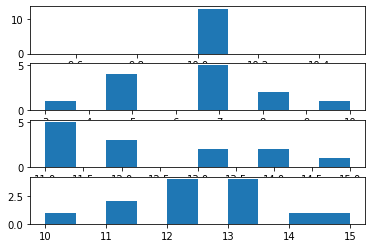

Mean Reward:  42.728


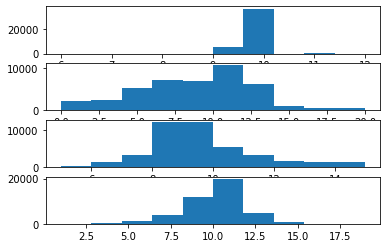

Mean Reward:  46.36


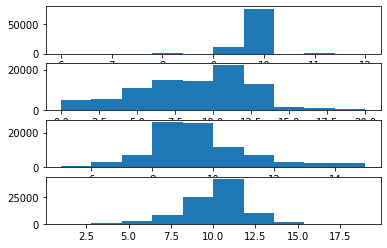

Mean Reward:  46.183


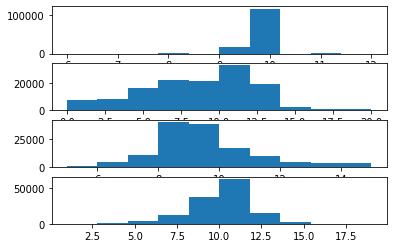

Mean Reward:  47.506


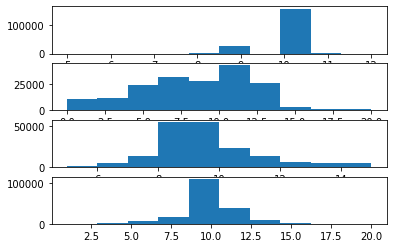

Mean Reward:  46.959


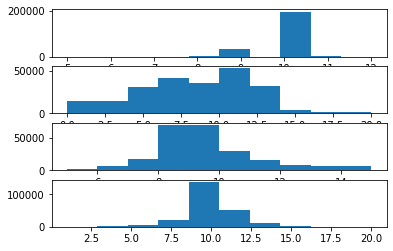

Mean Reward:  55.864


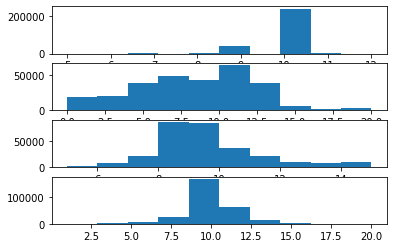

Mean Reward:  63.23


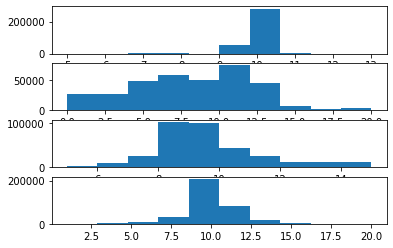

Mean Reward:  87.363


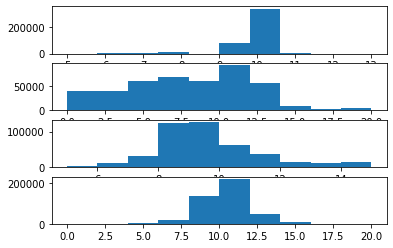

Mean Reward:  109.493


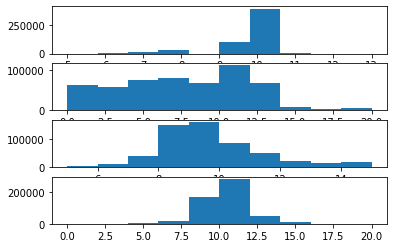

Mean Reward:  108.962


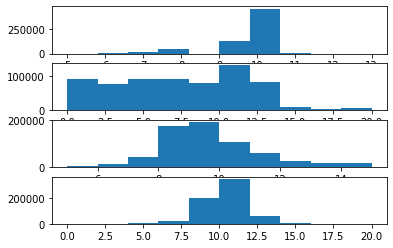

Mean Reward:  108.609


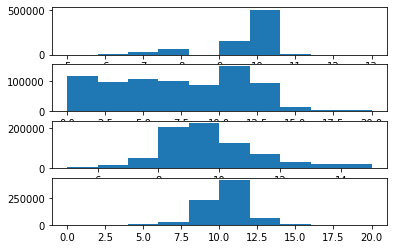

Mean Reward:  114.321


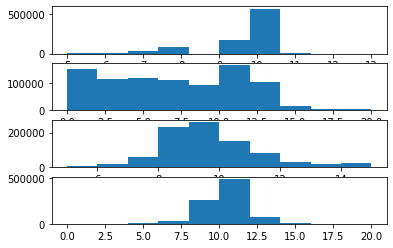

Mean Reward:  116.46


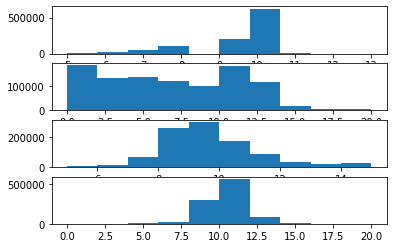

Mean Reward:  118.649


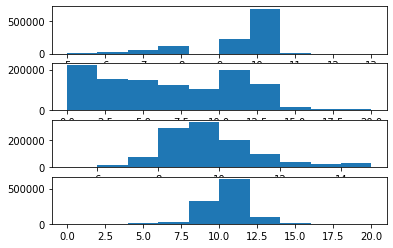

KeyboardInterrupt: 

In [4]:
q_learning(100000)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

MAX_EPISODE_LENGTH = 250
LEARNING_RATE = 1
DISCOUNT_FACTOR = 1

env = gym.make('CartPole-v0')

Q = nn.Linear(np.prod(env.observation_space.shape),
              env.action_space.n, bias=False)
Q.weight.data.uniform_(-10, 10)

optimizer = optim.SGD(Q.parameters(), lr=LEARNING_RATE)
BATCH_SIZE = 64


def policy(state, exploration_rate):
    if np.random.uniform(0, 1) < exploration_rate:
        return env.action_space.sample() 
    q_values = Q(torch.from_numpy(state).float()).detach().numpy()
    return np.argmax(q_values)


def vfa_update(states, actions, rewards, dones, next_states):
    optimizer.zero_grad()
    states = torch.from_numpy(np.array(states)).float()
    actions = torch.from_numpy(np.array(actions)).unsqueeze(-1)
    rewards = torch.from_numpy(np.array(rewards)).float()
    dones = torch.from_numpy(np.array(dones)).float()
    next_states = torch.from_numpy(np.array(next_states)).float()

    q_values = torch.gather(Q(states), dim=-1, index=actions).squeeze()
    target_q_values = rewards + \
        (1 - dones) * DISCOUNT_FACTOR * Q(next_states).max(dim=-1)[0].detach()
    loss = F.mse_loss(q_values, target_q_values)

    loss.backward()
    optimizer.step()
    return loss.item()


def q_learning(num_episodes, exploration_rate=0.1):
    rewards = []
    vfa_update_data = []
    losses = []
    for episode in range(num_episodes):
        rewards.append(0)
        obs = env.reset()
        state = obs

        for t in range(MAX_EPISODE_LENGTH):
            action = policy(state, exploration_rate)

            obs, reward, done, _ = env.step(action)

            next_state = obs
            vfa_update_data.append((state, action, reward, done, next_state))

            state = next_state

            rewards[-1] += reward

            if len(vfa_update_data) >= BATCH_SIZE:
                loss = vfa_update(*zip(*vfa_update_data))
                losses.append(loss)
                vfa_update_data.clear()

            if done:
                break

        if episode % (num_episodes / 10) == 0:
            print("Mean Reward: ", np.mean(rewards[-int(num_episodes / 100):]))
            print(Q.weight.detach().numpy())

In [6]:
q_learning(10000)

Mean Reward:  10.0
[[-5.654951   6.2767105  8.924599  -2.792879 ]
 [ 6.574463   9.844782   9.498394  -7.266526 ]]
Mean Reward:  10.39
[[-3.5217922 -1.5708778  2.1712356  1.2391762]
 [ 4.654927   7.345891  16.207872   2.092134 ]]
Mean Reward:  10.29
[[ 0.67922485 -5.40082    -6.6789975  -1.0306296 ]
 [ 1.4310004  10.260062   23.48918     3.8335392 ]]
Mean Reward:  10.28
[[  4.444463   -8.628428  -14.826058   -2.5653412]
 [ -1.6329012  13.496801   30.016232    4.1533456]]
Mean Reward:  10.32
[[  8.523289  -12.491485  -22.512505   -3.835315 ]
 [ -4.2516127  15.163994   35.934246    5.8535666]]
Mean Reward:  10.46
[[ 11.606243 -14.984815 -29.623703  -5.893032]
 [ -7.423439  17.26547   41.502964   6.326092]]
Mean Reward:  200.0
[[ 13.693744  -11.813905  -34.694992  -12.727852 ]
 [  0.9183985  17.174639   46.467346   15.937056 ]]
Mean Reward:  200.0
[[  6.326001  -12.777349  -36.68558   -12.883636 ]
 [  1.0701889  14.637278   48.21018    14.303224 ]]
Mean Reward:  200.0
[[  8.409244  -11.349

In [13]:
def policy(state):
    if state[2] < 0 > state[3]:
        return 0
    else:
        return 1

In [14]:
episode_reward = 0
state = env.reset()
done = False
while not done:
    action = policy(state)
    state, reward, done, _ = env.step(action)
    episode_reward += reward
    #env.render()
print(f"Episode Reward: {episode_reward}")

Episode Reward: 161.0
